# Objective: 
1. Tune parameters short_window and long_window to maximize profit
2. Learn signal generation
  

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import HTML

In [6]:
class CROSSOVER:
    ## class attribute: We can know the possible values for moving_average and metrics 
    ## before creating an object of the class 
    moving_average = ("Simple","exponential") 
    metrics = {'Sharpe':'Sharpe Ratio',
               'CAGR':'Compound Average Growth Rate',
               'MDD':'Maximum Drawdown',
               'NHR':'Normalized Hit Ratio',
               'OTS':'Optimal trade size'}
    
    def __init__(self,data,short_window = 5, long_window = 40,
                 moving_average = "Simple", data_name = None, start = None,end = None ):

        """
         Doc string of the class. We define what class is about here
        """
        self.data=data #the dataframe
        self.data['yr'] = self.data['Date'].dt.year
        self.moving_average = moving_average
        if data_name is None: #the name that will appear on plots
            self.data_name = moving_average
        else:
            self.data_name=data_name
        self.short_window = short_window
        self.long_window = long_window
        self.n_days = (self.data.Date.iloc[-1] - self.data.Date.iloc[0])
        self.start=start #the beginning date of the sample period
        self.end=end #the ending date of the sample period

    def generate_signals(self, charts=True, burn=False):
        """
        This is an instance method. Only works on an object.
        """
        if self.long_window <= self.short_window: return

        if self.moving_average == "Simple":
            self.data["SMA"] = self.data.Close.rolling(self.short_window).mean()
            self.data["LMA"] = self.data.Close.rolling(self.long_window).mean()
        elif self.moving_average == "exponential":
            self.data["SMA"] = self.data.Close.ewm(span = self.short_window, adjust=True).mean()
            self.data["LMA"] = self.data.Close.ewm(span = self.long_window, adjust=True).mean()
        else:
            raise Exception("Not a valid type")

        self.data["_lag1_SMA"] = self.data.SMA.shift(1)
        self.data["_lag1_LMA"] = self.data.LMA.shift(1)

        ## creating signal    
        buy_mask = (self.data.SMA > self.data.LMA) & (self.data._lag1_SMA < self.data._lag1_LMA)
        sell_mask = (self.data.SMA < self.data.LMA) & (self.data._lag1_SMA > self.data._lag1_LMA)

        self.data['signal'] = np.nan
        self.data.loc[buy_mask,'signal'] = +1
        self.data.loc[sell_mask,'signal'] = -1
        if burn:
            burn_period = 2*self.long_window
            self.data.loc[:burn_period,"signal"] = np.nan
        self.data.signal = self.data.signal.fillna(method="ffill")

        mask = (self.data.signal != self.data.signal.shift(1)) & (self.data.signal.notnull())
        self.data['trade_num'] = np.where(mask,1,0).cumsum()

        ## display chart
        if charts:
            plt.plot(self.data['Date'],self.data['SMA'],color='black', label=f'SMA ={self.short_window}')
            plt.plot(self.data['Date'],self.data['LMA'],color='blue', label=f'LMA ={self.long_window}')
            plt.title('%s Strategy Backtest'%(self.data_name))
            plt.legend(loc=0)
            d_color = {}
            d_color[1] = '#90ee90'  ## light green
            d_color[-1] = "#ffcccb" ## light red

            j = 0
            for i in range(1,self.data.shape[0]):
                if np.isnan(self.data.signal[i-1]):
                    j=i
                elif (self.data.signal[i-1] == self.data.signal[i]) and (i< (self.data.shape[0]-1)):
                    continue
                else:
                    plt.axvspan(self.data['Date'][j], self.data['Date'][i], 
                               alpha=0.5, color=d_color[self.data.signal[i-1]], label="interval")
                    j = i
            plt.show()
        
    def signal_performance(self, allocation):
        """
        Another instance method
        """
        if self.long_window <= self.short_window: return
        self.allocation=allocation

        #creating returns and portfolio value series
        self.data['Return']=np.log(self.data['Close']/self.data['Close'].shift(1))
        self.data['S_Return']=self.data['signal'].shift(1)*self.data['Return']
        self.data['Market_Return']=self.data['Return'].expanding().sum()
        self.data['Strategy_Return']=self.data['S_Return'].expanding().sum()
        self.data['Portfolio Value']=((self.data['Strategy_Return']+1)*self.allocation)
        self.data['Wins']=np.where(self.data['S_Return'] > 0,1,0)
        self.data['Losses']=np.where(self.data['S_Return']<0,1,0)

        ## Daywise Performance
        d_perform = {}
        d_perform['TotalWins']=self.data['Wins'].sum()
        d_perform['TotalLosses']=self.data['Losses'].sum()
        d_perform['TotalTrades']=d_perform['TotalWins']+d_perform['TotalLosses']
        d_perform['HitRatio']=round(d_perform['TotalWins']/d_perform['TotalTrades'],2)
        d_perform['SharpeRatio'] = self.data["S_Return"].mean() / self.data["S_Return"].std() * (252**.5)        
        d_perform['CAGR'] = (1+self.data['Strategy_Return']).iloc[-1]**(365.25/self.n_days.days) -1
        d_perform['MaxDrawdown']=(1.0-self.data['Portfolio Value']/self.data['Portfolio Value'].cummax()).max()
        self.daywise_performance = pd.Series(d_perform)

        ## Tradewise performance
        _df = self.data.groupby(["signal","trade_num"]).S_Return.sum().reset_index()
        _df['Wins']=np.where(_df['S_Return'] > 0,1,0)
        _df['Losses']=np.where(_df['S_Return']<0,1,0)
        d_tp = {}
        d_tp.update(_df[["Wins","Losses"]].sum().rename({'Wins':'TotalWins','Losses':'TotalLosses'}).to_dict())
        d_tp['TotalTrades'] = d_tp["TotalWins"] + d_tp["TotalLosses"]
        d_tp['HitRatio'] =  np.round(d_tp["TotalWins"] / d_tp['TotalTrades'],4)
        d_tp['AvgWinRet'] = np.round(_df[_df.Wins==1].S_Return.mean(),4)
        d_tp['AvgLossRet'] = np.round(_df[_df.Losses==1].S_Return.mean(),4)
        d_tp['WinByLossRet'] = np.round(abs(d_tp['AvgWinRet']/d_tp['AvgLossRet']),2)
        d_tp['RetVar'] = np.round(_df.S_Return.std(),4)
        _sum = _df.groupby("Wins").S_Return.sum()
        d_tp['NormHitRatio'] = np.round(_sum[1]/_sum.abs().sum(),4)
        d_tp['OptimalTradeSize'] = self.kelly(p = d_tp['HitRatio'], b = d_tp['WinByLossRet'])
        self.tradewise_performance = pd.Series(d_tp)

    @staticmethod
    def kelly(p,b):
        """
        Static method: No object or class related arguments
        p: win prob, b: net odds received on wager, output(f*) = p - (1-p)/b

        Spreadsheet example
            from sympy import symbols, solve, diff
            x = symbols('x')
            y = (1+3.3*x)**37 *(1-x)**63
            solve(diff(y, x), x)[1]
        Shortcut
            .37 - 0.63/3.3
        """
        return np.round(p - (1-p)/b,4)

    def plot_performance(self, allocation=1):
        #intializing a variable for initial allocation
        #to be used to create equity curve
        self.signal_performance(allocation)
        
        #yearly performance
        self.yearly_performance()
        
        #Plotting the Performance of the strategy
        plt.plot(self.data['Date'],self.data['Market_Return'],color='black', label='Market Returns')
        plt.plot(self.data['Date'],self.data['Strategy_Return'],color='blue', label= 'Strategy Returns')
        plt.title('%s Strategy Backtest'%(self.data_name))
        plt.legend(loc=0)
        plt.tight_layout()
        plt.show()

        plt.plot(self.data['Date'],self.data['Portfolio Value'], color='blue')
        plt.title('%s Portfolio Value'%(self.data_name))
        plt.show()
        
    def yearly_performance(self):
        """
        Instance method
        Adds an instance attribute: yearly_df
        """
        _yearly_df = self.data.groupby(['yr','signal']).S_Return.sum().unstack()
        _yearly_df.rename(columns={-1.0:'Sell',1.0:'Buy'}, inplace=True)
        _yearly_df['Return'] = _yearly_df.sum(1)

        # yearly_df
        self.yearly_df = _yearly_df.style.bar(color=["#ffcccb",'#90ee90'], align = 'zero').format({
            'Sell': '{:,.2%}'.format,'Buy': '{:,.2%}'.format,'Return': '{:,.2%}'.format})
    
    def update_metrics(self):
        """
        Called from the SMA_LMA_matrix class method
        """
        d_field = {}
        if self.long_window > self.short_window:
            d_field['Sharpe'] = self.daywise_performance.SharpeRatio
            d_field['CAGR'] = self.daywise_performance.CAGR
            d_field['MDD'] = self.daywise_performance.MaxDrawdown
            d_field['NHR'] = self.tradewise_performance.NormHitRatio
            d_field['OTS'] = self.tradewise_performance.OptimalTradeSize
            
        return d_field
    
    @classmethod
    def SMA_LMA_matrix(cls,data, LMA_range, SMA_range, metrics, moving_average = "Simple", optimal_sol = True):
        """
        This is a class method. First argument is a class.
        """
        c_green = sns.light_palette("green", as_cmap=True)
        c_red = sns.light_palette("red", as_cmap=True)
        
        d_mats = {m:[] for m in metrics}
        
        for l in LMA_range:
            d_row = {m:[] for m in metrics}
            for s in SMA_range:
                obj = cls(data, s, l, moving_average) ## object being created from the class
                obj.generate_signals(charts=False)
                obj.signal_performance(100)
                d_field = obj.update_metrics()
                for m in metrics: d_row[m].append(d_field.get(m,np.nan))
            for m in metrics: d_mats[m].append(d_row[m])
                
        d_df = {m:pd.DataFrame(d_mats[m], index=LMA_range, columns=SMA_range) for m in metrics}

        def optimal(_df):
            """ 
            This is a function inside a function.
            We could have created it outside the class if needed, but that would made it harder to relate. 
            """
            _df = _df.stack().rank()
            _df = (_df - _df.mean())/_df.std()
            return _df.unstack()

        if optimal_sol:
            d_df['Signal'] = 0
            if 'Sharpe' in metrics: d_df['Signal'] += 2*optimal(d_df['Sharpe'])
            if 'NHR' in metrics: d_df['Signal'] += optimal(d_df['NHR'])
            if 'CAGR' in metrics: d_df['Signal'] += optimal(d_df['CAGR'])
            if 'MDD' in metrics: d_df['Signal'] -= 2*optimal(d_df['MDD'])
            l_i,s_i = np.unravel_index(np.argmax(d_df['Signal'].values), d_df['Signal'].shape)
            print(f"Most optimal cross-over pair is SMA:{SMA_range[s_i]}, LMA:{LMA_range[l_i]}")
            metrics.insert(0,'Signal')

        for m in metrics:
            display(HTML(d_df[m].style.background_gradient(axis=None, cmap=
                c_red if m=="MDD" else c_green).format(
                ("{:,.2}" if m in ["Sharpe","Signal"] else "{:.2%}")).set_caption(m).render()))
            
        return d_df

In [7]:
close_df = pd.read_csv("class_data.csv", parse_dates = [0])

In [8]:
close_df.head()

,Date,Close
0,2000-01-03,1592.2
1,2000-01-04,1638.7
2,2000-01-05,1595.8
3,2000-01-06,1617.6
4,2000-01-07,1613.3


In [9]:
close_df.Close.ewm(span = 20, adjust=False, min_periods=20).mean()

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
4230    8107.503277
4231    8100.393441
4232    8094.151208
4233    8095.051093
4234    8103.693846
Name: Close, Length: 4235, dtype: float64

In [10]:
CROSSOVER.metrics

{'Sharpe': 'Sharpe Ratio',
 'CAGR': 'Compound Average Growth Rate',
 'MDD': 'Maximum Drawdown',
 'NHR': 'Normalized Hit Ratio',
 'OTS': 'Optimal trade size'}

In [11]:
CROSSOVER.moving_average

('Simple', 'exponential')

In [12]:
# Possible values for metrics : 'Sharpe','CAGR','MDD','NHR','OTS'
_= CROSSOVER.SMA_LMA_matrix(close_df, SMA_range=range(5,21), LMA_range=range(25,90,5),
                    metrics = ['Sharpe','MDD','OTS'], moving_average='exponential')

Most optimal cross-over pair is SMA:5, LMA:30


,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
25,6.6,6.7,6.6,6.4,6.1,5.8,4.5,2.2,3.7,3.4,3.7,4.4,3.1,0.75,-0.3,-0.05
30,6.8,6.6,5.8,4.9,1.8,3.7,3.2,-0.47,3.4,2.7,0.58,-1.2,-0.32,0.6,-0.23,0.8
35,5.8,5.9,4.9,1.8,4.8,1.7,0.56,0.9,-0.65,-0.45,1.6,0.66,0.17,0.6,0.83,0.55
40,6.1,6.5,5.1,2.2,4.6,0.17,-0.53,0.2,3.1,-0.15,0.35,1.1,2.3,2.9,3.8,3.9
45,6.3,4.0,2.0,1.5,0.83,-1.3,1.1,-0.7,-0.13,1.1,2.0,3.1,3.6,1.9,2.7,1.6
50,5.6,1.4,0.98,4.2,0.37,2.1,2.3,0.53,2.6,2.9,1.1,0.96,1.5,0.33,1.1,0.7
55,3.5,2.4,4.2,3.5,1.1,0.43,1.1,0.37,0.5,-0.4,-1.2,-0.73,-0.63,-0.63,-0.53,-2.2
60,3.3,1.8,3.1,3.5,-0.13,-0.27,-1.0,-1.3,-2.7,-1.5,-2.2,-2.8,-2.3,-2.0,-2.9,-4.6
65,5.1,2.6,3.9,2.4,-1.9,-3.8,-2.8,-3.0,-1.7,-2.5,-4.1,-3.7,-4.5,-4.3,-6.0,-5.0
70,3.5,3.8,0.27,-2.4,-2.1,-3.7,-1.8,-1.6,-1.7,-4.3,-3.9,-5.2,-5.6,-6.4,-6.1,-6.4


,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
25,0.55,0.62,0.58,0.54,0.51,0.49,0.47,0.4,0.43,0.44,0.46,0.49,0.45,0.4,0.39,0.38
30,0.62,0.56,0.49,0.49,0.44,0.44,0.42,0.42,0.46,0.43,0.4,0.34,0.38,0.37,0.32,0.34
35,0.52,0.52,0.48,0.42,0.46,0.42,0.41,0.39,0.36,0.37,0.41,0.38,0.33,0.32,0.37,0.34
40,0.54,0.59,0.53,0.47,0.47,0.4,0.4,0.39,0.43,0.31,0.36,0.38,0.41,0.44,0.47,0.47
45,0.67,0.51,0.47,0.45,0.37,0.39,0.44,0.37,0.36,0.39,0.43,0.45,0.47,0.45,0.48,0.45
50,0.52,0.46,0.44,0.49,0.44,0.44,0.47,0.42,0.46,0.48,0.44,0.43,0.45,0.43,0.44,0.44
55,0.49,0.49,0.5,0.49,0.45,0.44,0.45,0.45,0.44,0.43,0.42,0.42,0.41,0.42,0.41,0.39
60,0.48,0.47,0.48,0.47,0.43,0.44,0.42,0.42,0.39,0.42,0.4,0.39,0.39,0.4,0.38,0.3
65,0.51,0.47,0.49,0.47,0.39,0.35,0.39,0.39,0.42,0.41,0.37,0.38,0.34,0.32,0.25,0.3
70,0.53,0.51,0.43,0.37,0.39,0.37,0.43,0.43,0.43,0.38,0.37,0.29,0.29,0.28,0.26,0.26


,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
25,22.25%,23.09%,24.43%,27.73%,27.55%,31.37%,38.04%,35.32%,33.68%,38.59%,39.29%,40.02%,41.22%,41.67%,43.72%,41.67%
30,19.42%,27.48%,27.97%,38.83%,43.03%,35.51%,33.23%,49.83%,40.35%,39.28%,41.67%,42.55%,41.67%,39.17%,39.17%,33.88%
35,35.57%,35.42%,38.67%,39.25%,33.23%,41.01%,43.29%,39.29%,41.67%,41.67%,39.64%,39.17%,38.27%,34.28%,36.10%,36.03%
40,35.09%,31.90%,39.25%,45.87%,38.95%,43.79%,45.23%,42.03%,38.25%,38.95%,38.95%,38.54%,36.03%,40.10%,40.10%,39.80%
45,35.30%,41.77%,45.87%,45.46%,37.63%,48.13%,45.22%,43.05%,39.66%,39.20%,40.78%,40.10%,40.10%,44.24%,45.22%,45.22%
50,36.46%,47.89%,45.46%,41.23%,51.69%,43.01%,45.08%,43.64%,43.35%,44.42%,46.84%,45.18%,46.50%,45.78%,46.80%,49.17%
55,42.98%,48.16%,41.23%,43.32%,48.23%,50.33%,47.98%,52.49%,49.97%,52.64%,54.52%,52.37%,47.60%,50.52%,47.38%,53.53%
60,43.24%,47.04%,43.32%,41.24%,52.26%,53.58%,56.10%,56.66%,59.89%,57.61%,60.74%,61.50%,58.01%,56.63%,58.26%,65.40%
65,39.17%,44.62%,41.24%,44.73%,51.48%,63.44%,59.98%,62.65%,65.56%,66.59%,67.81%,66.73%,66.73%,64.06%,69.37%,66.78%
70,44.49%,43.21%,47.46%,51.48%,54.70%,65.12%,66.71%,65.56%,66.59%,70.39%,66.73%,68.35%,69.94%,73.66%,71.41%,71.96%


,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
25,16.30%,18.27%,18.68%,17.67%,16.95%,16.91%,15.39%,14.26%,16.11%,16.06%,17.99%,20.13%,19.37%,17.26%,16.55%,16.02%
30,18.39%,17.46%,15.49%,15.98%,14.01%,17.00%,15.44%,15.70%,17.01%,16.51%,16.66%,14.47%,15.79%,14.23%,14.15%,13.65%
35,14.86%,16.08%,16.61%,15.99%,16.38%,13.75%,15.96%,14.27%,14.78%,14.65%,15.51%,15.10%,12.89%,13.24%,14.30%,13.10%
40,15.78%,20.58%,19.43%,15.59%,15.48%,14.15%,14.32%,13.75%,15.88%,11.68%,13.32%,13.95%,15.73%,18.48%,19.75%,20.36%
45,23.37%,18.62%,15.08%,15.88%,12.86%,14.00%,15.67%,14.05%,12.98%,15.04%,17.99%,18.29%,20.09%,20.28%,22.16%,19.52%
50,18.44%,15.97%,15.20%,18.48%,16.63%,16.26%,18.70%,16.60%,17.80%,20.28%,19.34%,18.65%,19.44%,19.02%,20.66%,20.95%
55,15.97%,16.10%,17.98%,17.72%,19.08%,18.39%,17.01%,17.85%,18.48%,19.27%,18.85%,19.73%,20.42%,20.09%,16.30%,16.11%
60,15.79%,14.91%,16.59%,19.49%,18.36%,17.65%,16.82%,17.78%,16.52%,19.76%,18.27%,18.58%,16.48%,16.55%,13.69%,10.99%
65,17.36%,17.16%,19.78%,17.24%,14.79%,13.89%,16.40%,16.01%,19.55%,18.41%,15.63%,15.32%,12.16%,11.38%,9.53%,10.54%
70,18.66%,18.44%,15.31%,14.08%,16.04%,16.00%,18.56%,18.94%,18.50%,14.06%,13.76%,10.53%,10.41%,10.42%,10.19%,10.33%


In [13]:
ema_strategy = CROSSOVER(close_df, moving_average='exponential', short_window = 15, long_window = 25)

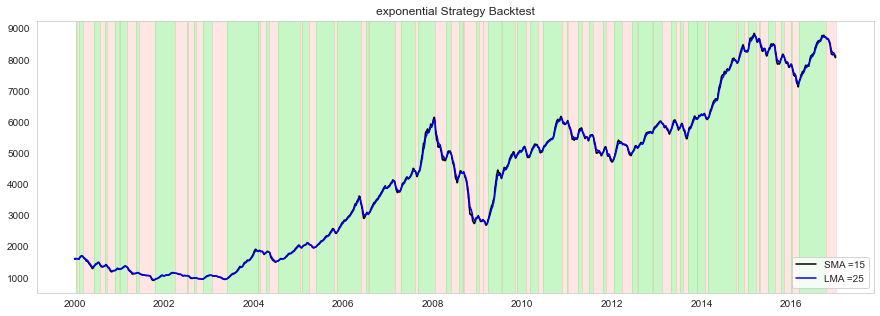

In [14]:
ema_strategy.generate_signals()

In [15]:
ema_strategy.data

,Date,Close,yr,SMA,LMA,_lag1_SMA,_lag1_LMA,signal,trade_num
0,2000-01-03,1592.20,2000,1592.200000,1592.200000,NaN,NaN,NaN,0
1,2000-01-04,1638.70,2000,1617.000000,1616.380000,1592.200000,1592.200000,NaN,0
2,2000-01-05,1595.80,2000,1608.971598,1608.964179,1617.000000,1616.380000,NaN,0
3,2000-01-06,1617.60,2000,1611.577935,1611.388831,1608.971598,1608.964179,NaN,0
4,2000-01-07,1613.30,2000,1612.019861,1611.834564,1611.577935,1611.388831,NaN,0
...,...,...,...,...,...,...,...,...,...
4230,2016-12-26,7908.25,2016,8080.940771,8133.922865,8105.610881,8152.728937,-1.0,105
4231,2016-12-27,8032.85,2016,8074.929425,8126.148029,8080.940771,8133.922865,-1.0,105
4232,2016-12-28,8034.85,2016,8069.919497,8119.125104,8074.929425,8126.148029,-1.0,105
4233,2016-12-29,8103.60,2016,8074.129560,8117.930865,8069.919497,8119.125104,-1.0,105


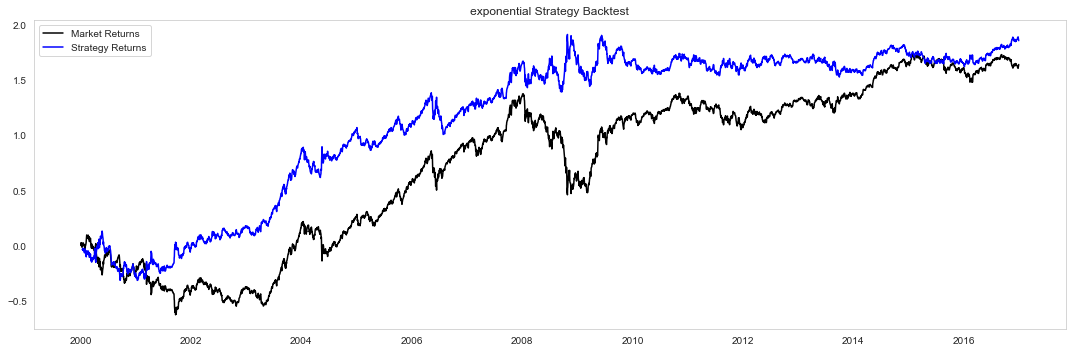

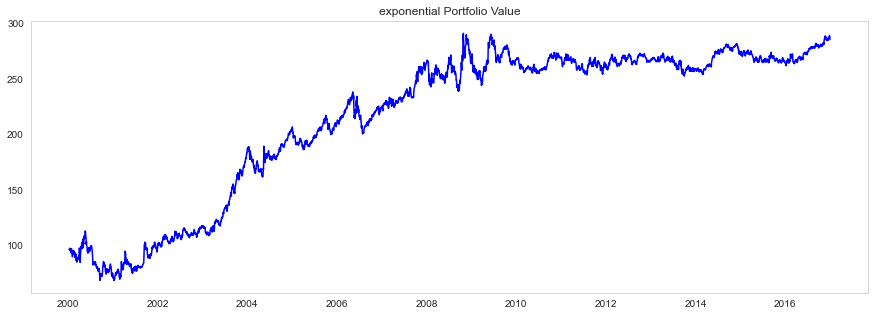

In [16]:
ema_strategy.plot_performance(100)

In [22]:
ema_strategy.daywise_performance

TotalWins      2175.000000
TotalLosses    2048.000000
TotalTrades    4223.000000
HitRatio          0.520000
SharpeRatio       0.460614
CAGR              0.063632
MaxDrawdown       0.392949
dtype: float64

In [18]:
ema_strategy.tradewise_performance

TotalWins            44.0000
TotalLosses          61.0000
TotalTrades         105.0000
HitRatio              0.4190
AvgWinRet             0.0978
AvgLossRet           -0.0402
WinByLossRet          2.4300
RetVar                0.1038
NormHitRatio          0.6371
OptimalTradeSize      0.1799
dtype: float64

In [19]:
ema_strategy.yearly_df

signal,Sell,Buy,Return
yr,,,
2000,-3.15%,-22.53%,-25.68%
2001,17.87%,5.85%,23.73%
2002,7.95%,11.43%,19.38%
2003,3.71%,62.54%,66.25%
2004,7.45%,13.98%,21.43%
2005,-13.86%,18.91%,5.05%
2006,-16.85%,30.88%,14.03%
2007,1.60%,38.55%,40.16%
2008,31.29%,-28.55%,2.75%


In [20]:
_df =close_df.groupby(["signal","trade_num"]).S_Return.sum().reset_index()


_df['Wins']=np.where(_df['S_Return'] > 0,1,0)
_df['Losses']=np.where(_df['S_Return']<0,1,0)
d_tp = {}
d_tp.update(_df[["Wins","Losses"]].sum().rename({'Wins':'TotalWins','Losses':'TotalLosses'}).to_dict())
d_tp
    

{'TotalWins': 44, 'TotalLosses': 61}